#  European Option Pricing and Structured Products
This notebook demonstrates how to price European call and put options using the analytical Black-Scholes model and a numerical Monte Carlo simulation. 
It also includes a function to calculate the price of a digital option. The notebook is structured as follows:
1. **Imports**: Import necessary libraries.
2. **Black-Scholes Function**: Define a function to calculate the price of European call and put options using the Black-Scholes formula.
3. **Monte Carlo Simulation**: Define a function to simulate the price of European call and put options using Monte Carlo methods.
4. **Digital Option Pricing**: Define a function to calculate the price of a digital option.
5. **Example Usage**: Provide examples of how to use the functions defined above.


In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(42)  # 42 

##  Black-Scholes Pricing Formula

In [2]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    Computes the Black-Scholes price for European options.
    S: spot price
    K: strike price
    T: time to maturity (in years)
    r: risk-free rate (annualized)
    sigma: volatility (annualized)
    option_type: 'call' or 'put'
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

## Greeks Calculation

In [3]:
def black_scholes_greeks(S, K, T, r, sigma, option_type='call'):
    """
    Computes the main Greeks for a European option using the Black-Scholes model.
    Returns a dictionary with Delta, Gamma, Vega, Theta, and Rho.
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    pdf = norm.pdf(d1)
    delta = norm.cdf(d1) if option_type == 'call' else norm.cdf(d1) - 1
    gamma = pdf / (S * sigma * np.sqrt(T))
    vega = S * pdf * np.sqrt(T) / 100
    theta = (-S * pdf * sigma / (2 * np.sqrt(T)) \
             - r * K * np.exp(-r*T) * (norm.cdf(d2) if option_type=='call' else norm.cdf(-d2))) / 365
    rho = K * T * np.exp(-r*T) * (norm.cdf(d2) if option_type=='call' else -norm.cdf(-d2)) / 100
    return {'Delta': delta, 'Gamma': gamma, 'Vega': vega, 'Theta': theta, 'Rho': rho}


## Monte Carlo Simulation for European Option

In [4]:
def monte_carlo_price(S, K, T, r, sigma, n_sim=100000, option_type='call'):
    """
    Prices a European option using Monte Carlo simulation.
    """
    Z = np.random.normal(0, 1, n_sim)
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)
    return np.exp(-r*T) * np.mean(payoff)


## Example: Pricing a Call Option

In [5]:
S = 100       # Spot price
K = 100       # Strike price
T = 1         # Maturity in years
r = 0.05      # Risk-free rate
sigma = 0.2   # Volatility
option_type = 'call'

bs_price = black_scholes_price(S, K, T, r, sigma, option_type)
mc_price = monte_carlo_price(S, K, T, r, sigma, n_sim=100000, option_type=option_type)
greeks = black_scholes_greeks(S, K, T, r, sigma, option_type)

print(f"Black-Scholes Price: {bs_price:.4f}")
print(f"Monte Carlo Price  : {mc_price:.4f}")
print("Greeks:")
for g, v in greeks.items():
    print(f"  {g}: {v:.4f}")


Black-Scholes Price: 10.4506
Monte Carlo Price  : 10.4739
Greeks:
  Delta: 0.6368
  Gamma: 0.0188
  Vega: 0.3752
  Theta: -0.0176
  Rho: 0.5323


## Visualization: Option Price and Greeks vs. Spot Price

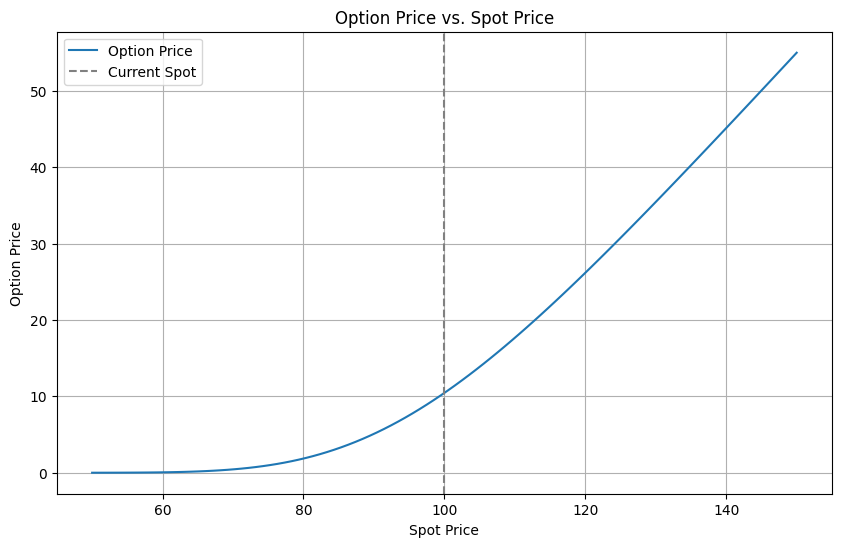

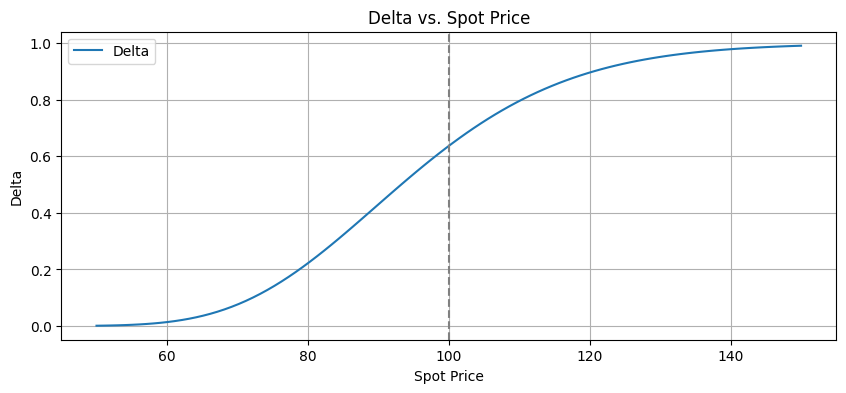

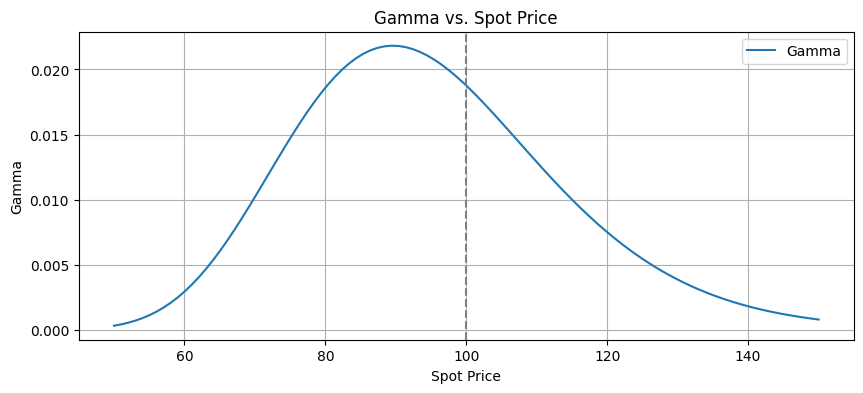

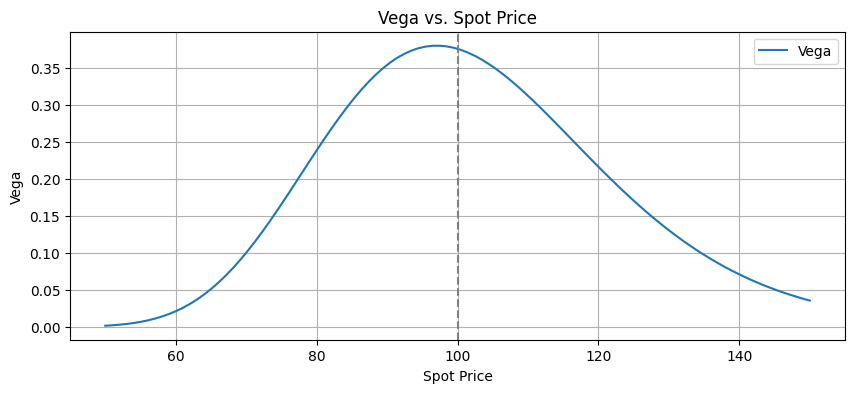

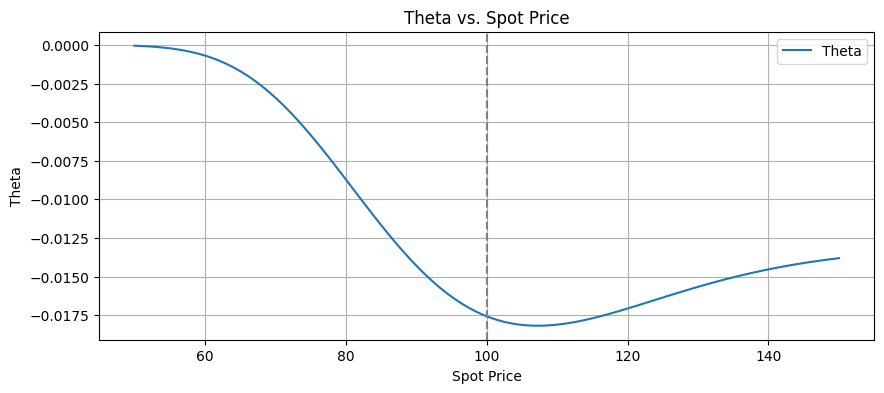

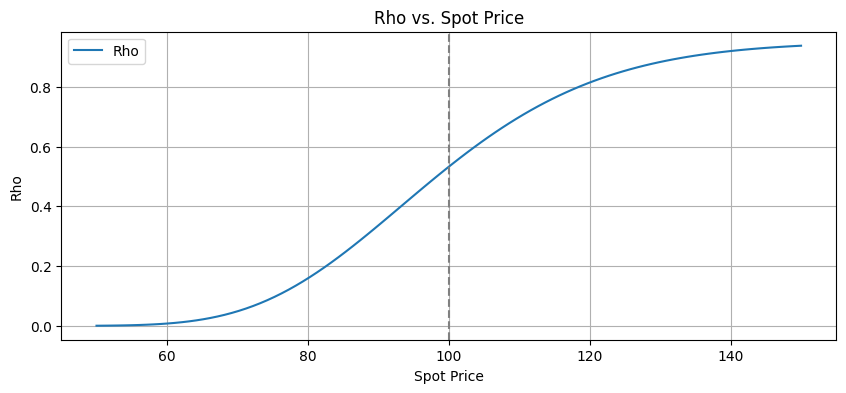

In [6]:
spot_range = np.linspace(50, 150, 100)
bs_prices = [black_scholes_price(s, K, T, r, sigma, option_type) for s in spot_range]

greek_curves = {g: [] for g in ['Delta', 'Gamma', 'Vega', 'Theta', 'Rho']}
for s in spot_range:
    g = black_scholes_greeks(s, K, T, r, sigma, option_type)
    for key in greek_curves:
        greek_curves[key].append(g[key])

plt.figure(figsize=(10, 6))
plt.plot(spot_range, bs_prices, label='Option Price')
plt.axvline(S, color='gray', linestyle='--', label='Current Spot')
plt.title('Option Price vs. Spot Price')
plt.xlabel('Spot Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

for greek, values in greek_curves.items():
    plt.figure(figsize=(10, 4))
    plt.plot(spot_range, values, label=greek)
    plt.axvline(S, color='gray', linestyle='--')
    plt.title(f'{greek} vs. Spot Price')
    plt.xlabel('Spot Price')
    plt.ylabel(greek)
    plt.legend()
    plt.grid(True)
    plt.show()


##  Exotic Option: Digital Option Pricing
A digital (binary) option pays a fixed payout if the underlying asset meets a condition at expiration. 
Here, we provide both closed-form and Monte Carlo approaches for pricing a digital call option.

In [7]:
def digital_option_closed(S, K, T, r, sigma, option_type='call', payout=1):
    """
    Computes the closed-form price of a digital (binary) option using the Black-Scholes model.
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        return payout * np.exp(-r*T) * norm.cdf(d2)
    else:
        return payout * np.exp(-r*T) * norm.cdf(-d2)

def digital_option_mc(S, K, T, r, sigma, n_sim=100000, option_type='call', payout=1):
    """
    Prices a digital option via Monte Carlo simulation.
    """
    Z = np.random.normal(0, 1, n_sim)
    ST = S * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    if option_type == 'call':
        payoff = np.where(ST > K, payout, 0)
    else:
        payoff = np.where(ST < K, payout, 0)
    return np.exp(-r*T) * np.mean(payoff)


### Example: Digital Call Option Pricing

Digital Option (Closed-form): 0.5323
Digital Option (Monte Carlo) : 0.5332


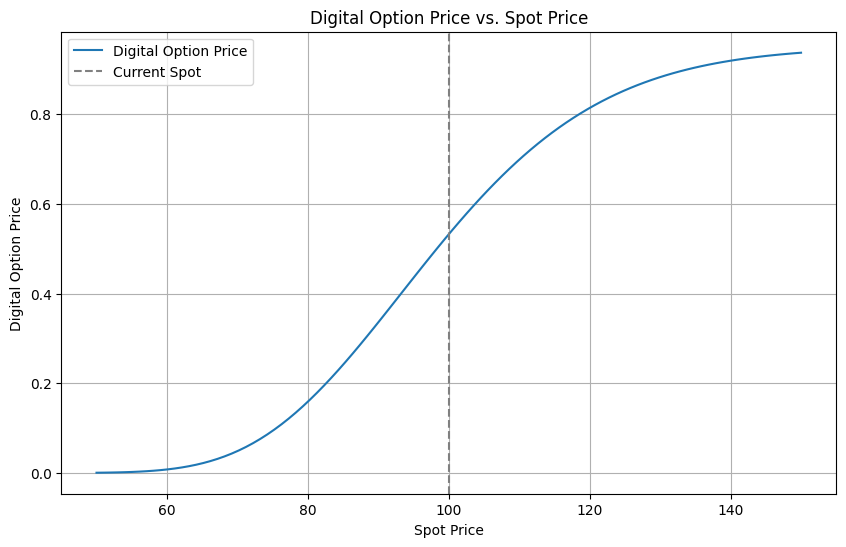

In [8]:
digital_closed = digital_option_closed(S, K, T, r, sigma, option_type='call', payout=1)
digital_mc = digital_option_mc(S, K, T, r, sigma, n_sim=100000, option_type='call', payout=1)
print(f"Digital Option (Closed-form): {digital_closed:.4f}")
print(f"Digital Option (Monte Carlo) : {digital_mc:.4f}")

# Plot digital option price vs. varying spot price
spot_range = np.linspace(50, 150, 100)
digital_prices = [digital_option_closed(s, K, T, r, sigma, option_type='call', payout=1) for s in spot_range]

plt.figure(figsize=(10, 6))
plt.plot(spot_range, digital_prices, label='Digital Option Price')
plt.axvline(S, color='gray', linestyle='--', label='Current Spot')
plt.title('Digital Option Price vs. Spot Price')
plt.xlabel('Spot Price')
plt.ylabel('Digital Option Price')
plt.legend()
plt.grid(True)
plt.show()


##  Structured Product: Autocallable Option Simulation
An autocallable product is a structured note that can be called early if the underlying asset reaches a certain level. In this simplified simulation:

- The product is monitored at the end of each year.
- If the underlying is above a specified **barrier**, the product is auto-called and pays the principal plus a cumulative coupon.
- If not called early, the final payoff depends on the underlying's performance relative to a protection barrier.


In [9]:
def simulate_autocall(S, barrier, protection_barrier, coupon, T, r, sigma, n_sim=10000):
    """
    Simulates an autocallable structured product with annual observations.
    Parameters:
      S: initial spot price (principal)
      barrier: trigger multiplier for auto-call (e.g., 1.1 means 110% of S)
      protection_barrier: lower threshold multiplier (e.g., 0.7 means 70% of S)
      coupon: annual coupon paid when auto-called or at maturity
      T: maturity in years (integer)
      r: risk-free rate
      sigma: annual volatility
      n_sim: number of simulation paths
    Returns:
      Estimated product price
    """
    payoffs = []
    for _ in range(n_sim):
        auto_called = False
        for t in range(1, T):  # observations from year 1 to T-1
            ST = S * np.exp((r - 0.5*sigma**2)*t + sigma*np.sqrt(t)*np.random.normal())
            if ST >= barrier * S:
                payoff = (S + coupon * t) * np.exp(-r * t)
                auto_called = True
                break
        if not auto_called:
            ST = S * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*np.random.normal())
            if ST >= protection_barrier * S:
                payoff = (S + coupon * T) * np.exp(-r * T)
            else:
                payoff = ST * np.exp(-r * T)
        payoffs.append(payoff)
    return np.mean(payoffs)


### Example: Autocallable Option Simulation

In [10]:
S = 100
barrier = 1.1          # Auto-call if underlying >= 110% of S
protection_barrier = 0.7 # Protection: if underlying < 70% of S at maturity
coupon = 5             # Annual coupon
T = 5                  # Maturity in years
r = 0.03               # Risk-free rate
sigma = 0.25           # Volatility

autocall_price = simulate_autocall(S, barrier, protection_barrier, coupon, T, r, sigma, n_sim=10000)
print(f"Autocallable Product Price: {autocall_price:.4f}")


Autocallable Product Price: 101.8111


##  Sensitivity Analysis: Option Price vs. Volatility

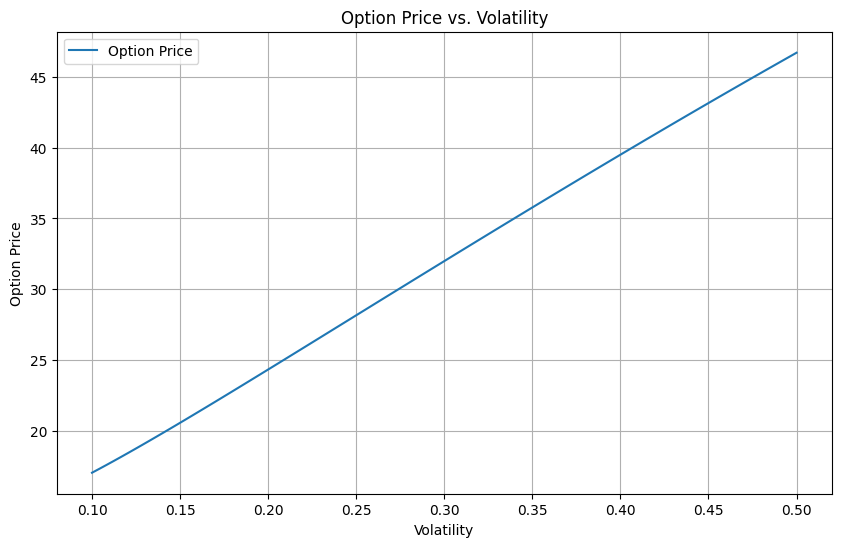

In [12]:
vol_range = np.linspace(0.1, 0.5, 100)
option_prices = [black_scholes_price(S, K, T, r, vol, option_type) for vol in vol_range]

plt.figure(figsize=(10, 6))
plt.plot(vol_range, option_prices, label='Option Price')
plt.title('Option Price vs. Volatility')
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()
